In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

# Xopt class, TNK test function

This is the class method for running Xopt.

TNK function
$n=2$ variables:
$x_i \in [0, \pi], i=1,2$

Objectives:
- $f_i(x) = x_i$

Constraints:
- $g_1(x) = -x_1^2 -x_2^2 + 1 + 0.1 \cos\left(16 \arctan \frac{x_1}{x_2}\right) \le 0$
- $g_2(x) = (x_1 - 1/2)^2 + (x_2-1/2)^2 \le 0.5$

In [2]:
# Import the class
from xopt import Xopt

The `Xopt` object can be instantiated from a JSON or YAML file, or a dict, with the proper structure.

Here we will make one

In [3]:
import yaml
# Make a proper input file. 
YAML="""
xopt: {output_path: null, verbose: true}

algorithm:
  name: bayesian_exploration
  options: {n_initial_samples: 5,
            use_gpu: False,
            n_steps: 20, 
            verbose: True}
  
simulation: 
  name: test_TNK
  evaluate: xopt.evaluators.test_TNK.evaluate_TNK  
  
vocs:
  name: TNK_test
  description: null
  simulation: test_TNK
  templates: null
  variables:
    x1: [0, 3.14159]
    x2: [0, 3.14159]
  objectives: {y1: None}
  constraints:
    c1: [GREATER_THAN, 0]
    c2: ['LESS_THAN', 0.5]
  linked_variables: {x9: x1}
  constants: {a: dummy_constant}

"""
config = yaml.safe_load(YAML)

In [4]:
# Optional: Connect the function directly
#from xopt.evaluators.test_TNK import evaluate_TNK 
#config['simulation']['evaluate'] = evaluate_TNK 

X = Xopt(config)
X

Loading config as dict.



            Xopt 
________________________________           
Version: 0.4.3
Configured: True
Config as YAML:
xopt: {output_path: null, verbose: true}
algorithm:
  name: bayesian_exploration
  function: xopt.bayesian_exploration.bayesian_exploration
  options: {n_initial_samples: 5, use_gpu: false, n_steps: 20, verbose: true}
simulation:
  name: test_TNK
  evaluate: xopt.evaluators.test_TNK.evaluate_TNK
  options: {extra_option: abc}
vocs:
  name: TNK_test
  description: null
  simulation: test_TNK
  templates: null
  variables:
    x1: [0, 3.14159]
    x2: [0, 3.14159]
  objectives: {y1: None}
  constraints:
    c1: [GREATER_THAN, 0]
    c2: [LESS_THAN, 0.5]
  linked_variables: {x9: x1}
  constants: {a: dummy_constant}

In [5]:
# Note that the repr string contains all of the config information
X.random_evaluate()

{'y1': 1.246512204862633,
 'y2': 2.9007254728982272,
 'c1': 8.870211640899418,
 'c2': 6.320763268231286,
 'some_array': array([1, 2, 3])}

# Run CNSGA

CNSGA is designed to run in parallel with an asynchronous executor as defined in PEP 3148

In [6]:
# Pick one of these
from concurrent.futures import ThreadPoolExecutor as PoolExecutor
#from concurrent.futures import ProcessPoolExecutor as PoolExecutor

executor = PoolExecutor()
# This will also work. 
#executor=None

In [7]:
# Change max generations
X.run(executor=executor)

Starting at time 2021-08-04T10:24:25-05:00
tensor([[0.2792, 0.4639]], dtype=torch.float64)
6
tensor([[0.9320, 0.9352]], dtype=torch.float64)
7
tensor([[0.0000, 1.1984]], dtype=torch.float64)
8
tensor([[0.6292, 1.0423]], dtype=torch.float64)
9
tensor([[1.0020, 0.2338]], dtype=torch.float64)
10
tensor([[1.1069, 0.6179]], dtype=torch.float64)
11
tensor([[0.3235, 1.0827]], dtype=torch.float64)
12
tensor([[1.0067, 0.0978]], dtype=torch.float64)
13
tensor([[0.8232, 0.6844]], dtype=torch.float64)
14
tensor([[0.9723, 0.9839]], dtype=torch.float64)
15
tensor([[1.1717, 0.6273]], dtype=torch.float64)
16
tensor([[0.6489, 1.1504]], dtype=torch.float64)
17
tensor([[1.0307, 0.0657]], dtype=torch.float64)
18
tensor([[0.1685, 1.0565]], dtype=torch.float64)
19
tensor([[0.5980, 0.8358]], dtype=torch.float64)
20
tensor([[0.3902, 1.1716]], dtype=torch.float64)
21
tensor([[0.0000, 0.9322]], dtype=torch.float64)
22
tensor([[0.8735, 0.5280]], dtype=torch.float64)
23
tensor([[0.8226, 1.1055]], dtype=torch.floa

# Plot

tensor([[3.1175, 1.8267],
        [0.2910, 1.9205],
        [1.9441, 0.6129],
        [1.4840, 0.2225],
        [1.8743, 2.8733],
        [0.2792, 0.4639],
        [0.9320, 0.9352],
        [0.0000, 1.1984],
        [0.6292, 1.0423],
        [1.0020, 0.2338],
        [1.1069, 0.6179],
        [0.3235, 1.0827],
        [1.0067, 0.0978],
        [0.8232, 0.6844],
        [0.9723, 0.9839],
        [1.1717, 0.6273],
        [0.6489, 1.1504],
        [1.0307, 0.0657],
        [0.1685, 1.0565],
        [0.5980, 0.8358],
        [0.3902, 1.1716],
        [0.0000, 0.9322],
        [0.8735, 0.5280],
        [0.8226, 1.1055],
        [1.1500, 0.7321]], dtype=torch.float64)


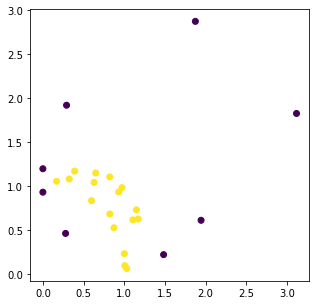

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

train_x = X.results['inputs']
print(train_x)
feas = X.results['feasibility']
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(*train_x.T, c = feas.int())
